# Demo procesamiento de imagen

Comenzaremos cargando las librerias necesarias para esta demo

In [2]:
import numpy as np               # el módulo numpy se asocia con alias np
import time                      # módulo de gestión del tiempo
import cv2                       # módulo de OpenCV
# las siguientes librerías permiten mostrar imágenes en el cuaderno
import matplotlib                # módulo de visualización
import matplotlib.pyplot as plt  # el módulo matplotlib.pyplot con alias plt
from IPython.display import clear_output, Image, display, HTML  
import tools_creaVideo as crea   # módulo para generar imágenes virtuales
import ipywidgets as widgets     # funcionalidad de interacción con las gráficas
from matplotlib import rcParams

## Segmentación

Su objetio es separar pixeles de fondo, de pixeles de interes

En primer lugar pasamos la imagen a procesar a escala de grises:

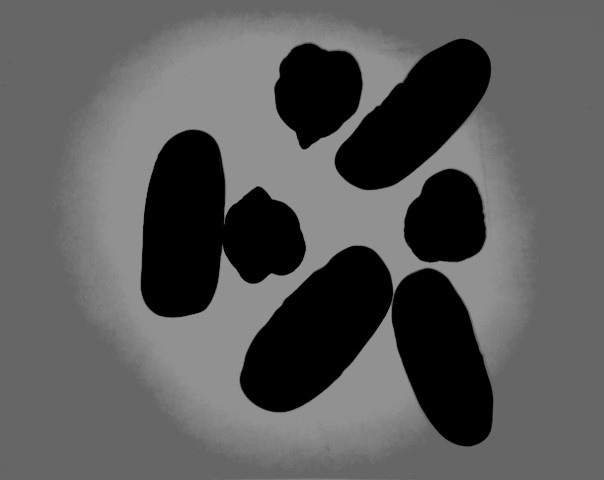

In [3]:
img = cv2.imread('imgs/demo2.jpg')
# Conversión a imagen de grises
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
i=img_gray.copy()
# Mostrar la imagen procesada
Image(cv2.imencode('.jpg', img_gray)[1])


Histograma de la imagen:

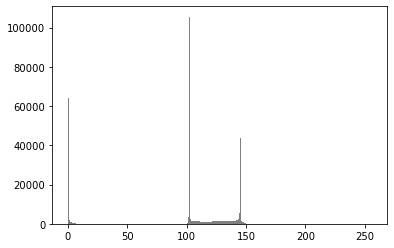

In [4]:
# Visualizar el histograma
plt.hist(img_gray.ravel(),256,[0,256], color = "gray")
plt.show()

#### Umbralización con el método de Otsu 

con umbral automático

--- 0.009067058563232422 seconds ---
Umbral aplicado: 59.0


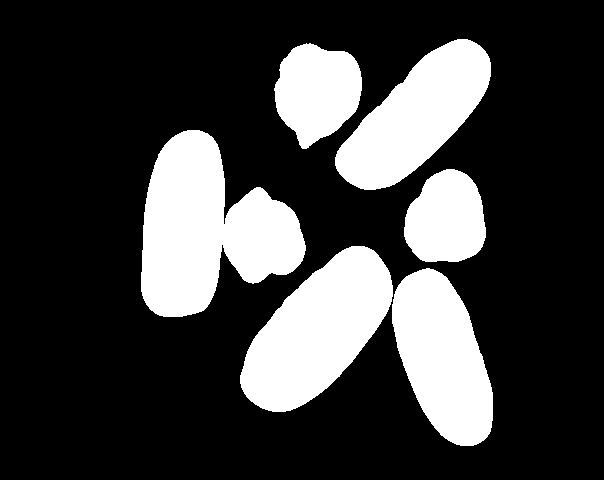

In [5]:
# Umbralización con el método de Otsu 
start_time = time.time()
umbral, img_segmentada = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
print("--- %s seconds ---" % (time.time() - start_time))
print("Umbral aplicado:", umbral)

# Mostrar la imagen segmentada
Image(cv2.imencode('.jpg', img_segmentada)[1])

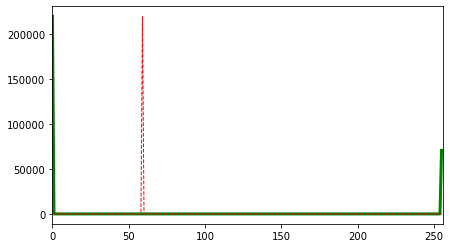

In [6]:
# Visualizar el histograma
fig = plt.subplots(figsize=(7, 4))
hist = cv2.calcHist([img_segmentada],[0],None,[256],[0,256])
plt.plot(hist, linewidth=3, color = 'green')
plt.xlim([0,256])
threshold_mark = np.zeros(256)
threshold_mark[int(umbral)] = np.max(hist)
plt.plot(threshold_mark, linewidth=1, linestyle='dashed', color = 'red')
plt.show()

#### Umbralización con OpenCV

Escogiendo el umbral manualmente

--- 0.0009906291961669922 seconds ---


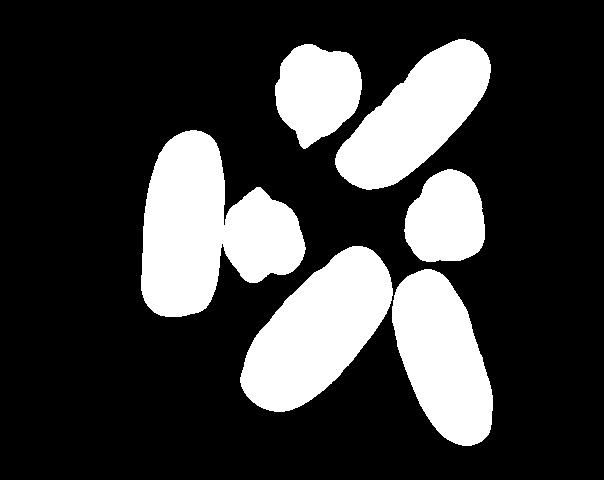

In [7]:
# Umbralización con OpenCV

umbral=25

start_time = time.time()
ret, img_segmentada = cv2.threshold(img_gray,umbral,255,cv2.THRESH_BINARY_INV)
print("--- %s seconds ---" % (time.time() - start_time))

# Mostrar la imagen procesada
Image(cv2.imencode('.jpg', img_segmentada)[1])

#### Umbralización con nuestro porpio algoritmo

Umbral seleccionado automáticamente

--- 0.615581750869751 seconds ---
Umbral aplicado: 62


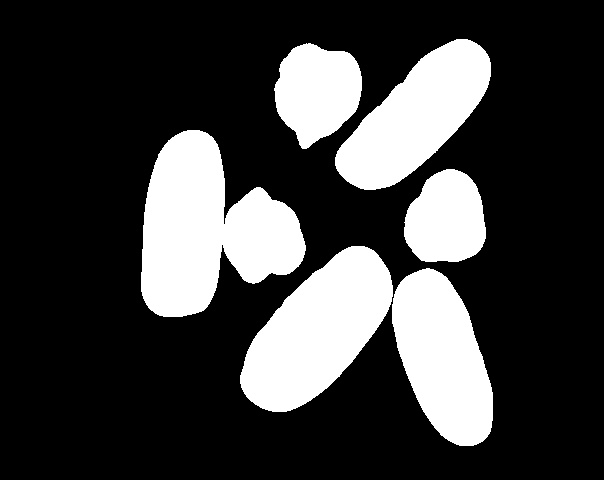

In [8]:
start_time = time.time()
val_inf=[]
val_sup=[]
cont_bueno=0
img_segment_manual=img_gray.copy()

m_img=int(img.shape[0]/2)
img_red=i[m_img]
umbral_ini=img_red.mean()
umbral=int(umbral_ini)
#print(umbral)
while cont_bueno<10:
    for x in range(img_red.shape[0]):
        if (img_red[x]<umbral):
            val_inf.append(img_red[x])
        else:
            val_sup.append(img_red[x])

    media_inf=int(sum(val_inf)/len(val_inf))
    media_sup=int(sum(val_sup)/len(val_sup))

    if umbral==int(((media_inf+media_sup)/2)):
        umbral=int(((media_inf+media_sup)/2))
        cont_bueno=cont_bueno+1
    else:
        umbral=int(((media_inf+media_sup)/2))
        
for x in range(img_gray.shape[0]):
    for y in range(img_gray.shape[1]):
        if img_gray[x,y]<umbral:
            img_segment_manual[x,y]=255
        else:
            img_segment_manual[x,y]=0
            
print("--- %s seconds ---" % (time.time() - start_time))
print("Umbral aplicado:", umbral)

# Mostrar la imagen segmentada
Image(cv2.imencode('.jpg', img_segment_manual)[1])

## Separación de elementos conectados

Mediante erosión y dilatación

#### Implementación propia

Funciones auxiliares para añadir o quitar márgenes

In [9]:
def aumentar (img,margen):
    alto,ancho =img.shape
    img_grande=np.zeros((alto+2*margen,ancho+2*margen),dtype=img.dtype)
    img_grande[margen:(alto+margen),margen:(ancho+margen)]=img[:,:]
    return img_grande
def reducir (img,margen):
    alto,ancho =img.shape
    img_pequeña=np.zeros((alto-2*margen,ancho-2*margen),dtype=img.dtype)
    img_pequeña[:,:]=img[margen:(alto-margen),margen:(ancho-margen)]
    return img_pequeña
def aumentarChan (img,margen):
    alto,ancho,canal =img.shape
    img_grande=np.zeros((alto+2*margen,ancho+2*margen,canal),dtype=img.dtype)
    img_grande[margen:(alto+margen),margen:(ancho+margen)]=img[:,:]
    return img_grande
def reducirChan (img,margen):
    alto,ancho,canal =img.shape
    img_pequeña=np.zeros((alto-2*margen,ancho-2*margen,canal),dtype=img.dtype)
    img_pequeña[:,:]=img[margen:(alto-margen),margen:(ancho-margen)]
    return img_pequeña

Funciones de erosión y dilatación

In [10]:
def erosionar(img):
    img=aumentar(img,1)
    imgerosionada=img.copy()
    for x in range(1,img.shape[0]-1):
        for y in range(1,img.shape[1]-1):
            if (img[x,y]!=0):
                aux=img[x,y]
                if not((img[x-1,y-1]==aux)and(img[x-1,y]==aux)and(img[x-1,y+1]==aux)and(img[x,y-1]==aux)and(img[x,y+1]==aux)and(img[x+1,y-1]==aux)and(img[x+1,y]==aux)and(img[x+1,y+1]==aux)):
                    imgerosionada[x,y]=0
                    imgerosionada[x-1,y-1]=0
                    imgerosionada[x-1,y]=0
                    imgerosionada[x-1,y+1]=0
                    imgerosionada[x,y-1]=0
                    imgerosionada[x,y+1]=0
                    imgerosionada[x+1,y-1]=0
                    imgerosionada[x+1,y]=0
                    imgerosionada[x+1,y+1]=0
    return reducir(imgerosionada,1)

def dilatar(img):
    img=aumentar(img,1)
    imgdilatada=img.copy()
    for x in range(1,img.shape[0]-1):
        for y in range(1,img.shape[1]-1):
            if (img[x,y]!=0):
                aux=img[x,y]
                if not((img[x-1,y-1]==aux)and(img[x-1,y]==aux)and(img[x-1,y+1]==aux)and(img[x,y-1]==aux)and(img[x,y+1]==aux)and(img[x+1,y-1]==aux)and(img[x+1,y]==aux)and(img[x+1,y+1]==aux)):
                    imgdilatada[x-1,y-1]=aux
                    imgdilatada[x-1,y]=aux
                    imgdilatada[x-1,y+1]=aux
                    imgdilatada[x,y-1]=aux
                    imgdilatada[x,y+1]=aux
                    imgdilatada[x+1,y-1]=aux
                    imgdilatada[x+1,y]=aux
                    imgdilatada[x+1,y+1]=aux
    return reducir(imgdilatada,1)

Erosión de la imagen

--- 0.6852500438690186 seconds ---
--- 0.6634342670440674 seconds ---
--- 0.6556246280670166 seconds ---
--- 0.6344895362854004 seconds ---
--- 0.6206519603729248 seconds ---
--- 0.6082620620727539 seconds ---
---Total: 3.8677124977111816 seconds ---


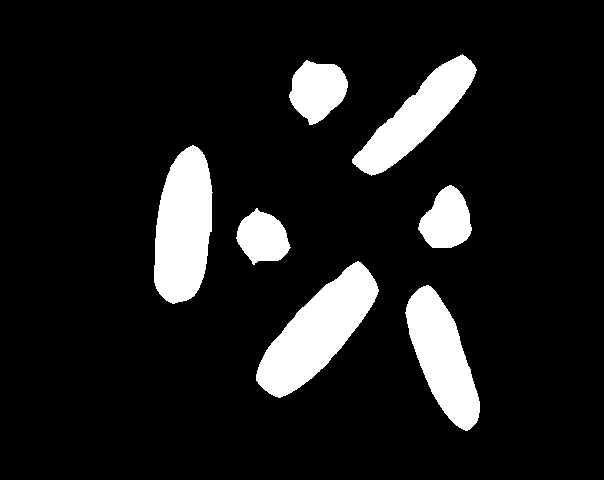

In [11]:
erosiones=6
img_erosion=img_segmentada.copy()
start_time = time.time()
for x in range(erosiones):
    funtime=time.time()
    img_erosion=erosionar(img_erosion)
    print("--- %s seconds ---" % (time.time() - funtime))
print("---Total: %s seconds ---" % (time.time() - start_time))
Image(cv2.imencode('.bmp',img_erosion)[1])

Dilatación de la imagen

--- 0.9775190353393555 seconds ---
--- 1.0151004791259766 seconds ---
--- 1.1183619499206543 seconds ---
--- 1.0068995952606201 seconds ---
--- 0.885554313659668 seconds ---
--- 0.6479873657226562 seconds ---
--- 0.648327112197876 seconds ---
--- 0.6952733993530273 seconds ---
--- 0.7392919063568115 seconds ---
--- 0.7404472827911377 seconds ---
---Total: 8.478766679763794 seconds ---


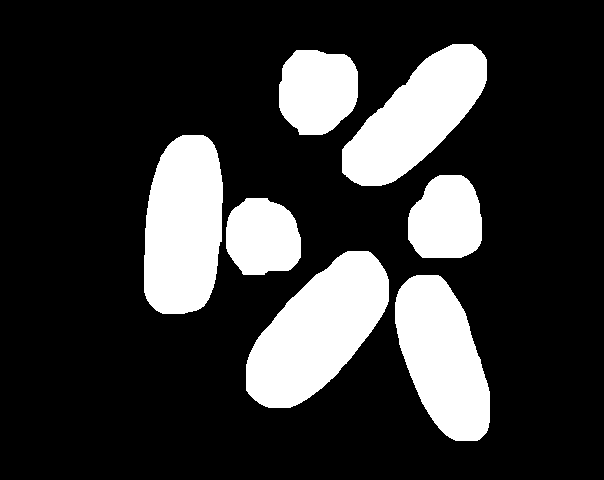

In [11]:
dilatados=10
#img_erosion=img_etiqueta.copy()
start_time = time.time()
for x in range(dilatados):
    funtime=time.time()
    img_erosion=dilatar(img_erosion)
    print("--- %s seconds ---" % (time.time() - funtime))
print("---Total: %s seconds ---" % (time.time() - start_time))
Image(cv2.imencode('.bmp',img_erosion)[1])

#### Implementación OpenCV

--- 0.012002229690551758 seconds ---


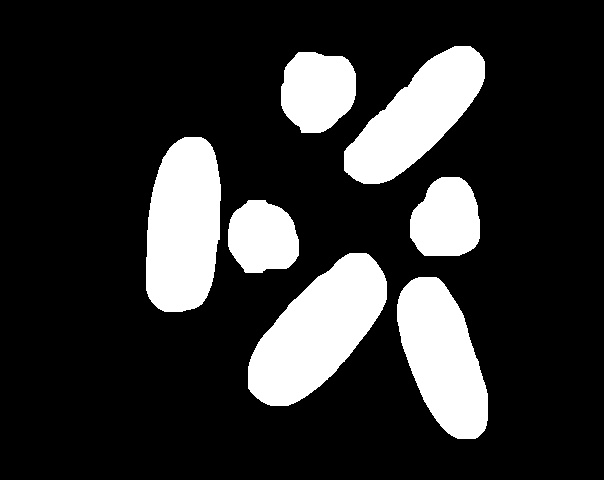

In [12]:
start_time = time.time()
kernel = np.ones((5,5),np.uint8)
img_erosionada = cv2.erode(img_segmentada,kernel,iterations = 6)

# Mostrar la imagen erosionada
Image(cv2.imencode('.jpg', img_erosionada)[1])

img_dilatada = cv2.dilate(img_erosionada,kernel,iterations = 4)
print("--- %s seconds ---" % (time.time() - start_time))

# Mostrar la imagen dilatada
Image(cv2.imencode('.jpg', img_dilatada)[1])

## Etiquetado

Su objetivo es identificar los diferentes objetos que aparecen en la imagen

In [13]:
def extender2(img,imgetiquetaO,umbral,xini,yini,N):
    alto, ancho = img.shape
    imgetiquetaO[xini,yini]=N
    imgetiqueta=aumentar(imgetiquetaO,1)
    x=xini+1
    y=yini+1
    xfin=min(xini+2,alto)
    yfin=min(yini+2,ancho)
    izq=1
    der=1
    arriba=1
    abajo=1
    cambio=False
    continuar=True
    while (continuar==True):
        if ((img[x-1,y-1]>umbral) and (imgetiqueta[x,y]==0) and ((imgetiqueta[x-arriba,y]==N)or(imgetiqueta[x,y-izq]==N)or(imgetiqueta[x+abajo,y]==N)or(imgetiqueta[x,y+der]==N)or(imgetiqueta[x+abajo,y+der]==N)or(imgetiqueta[x-arriba,y+der]==N)or(imgetiqueta[x+abajo,y-izq]==N)or(imgetiqueta[x-arriba,y-izq]==N))):
            imgetiqueta[x,y]=N
            cambio=True
            xfin=min(max(xfin,x+1),alto)
            yfin=min(max(yfin,y+1),ancho)
            xini=max(min(xini,x-1),1)
            yini=max(min(yini,y-1),1)
        y=y+1
        if (y>yfin):
            y=yini
            x=x+1
            if (x>xfin):
                x=xini
                if (cambio==False):
                    continuar=False
                else: 
                    imgetiqueta,continuar,xini,yini,xfin,yfin=extenderinv2(img,imgetiqueta,umbral,xini,yini,xfin,yfin,N)
                    x=xini
                    y=yini
    return reducir(imgetiqueta,1),xini-1,yini-1,xfin,yfin

def extenderinv2(img,imgetiqueta,umbral,xini,yini,xfin,yfin,N):
    alto, ancho = img.shape
    x=xfin
    y=yfin
    izq=1
    der=1
    arriba=1
    abajo=1
    cambio=False
    continuar=True
    while (continuar==True):
        if ((img[x-1,y-1]>umbral) and (imgetiqueta[x,y]==0) and ((imgetiqueta[x-arriba,y]==N)or(imgetiqueta[x,y-izq]==N)or(imgetiqueta[x+abajo,y]==N)or(imgetiqueta[x,y+der]==N)or(imgetiqueta[x+abajo,y+der]==N)or(imgetiqueta[x-arriba,y+der]==N)or(imgetiqueta[x+abajo,y-izq]==N)or(imgetiqueta[x-arriba,y-izq]==N))):
            imgetiqueta[x,y]=N
            cambio=True
            xfin=min(max(xfin,x+1),alto)
            yfin=min(max(yfin,y+1),ancho)
            xini=max(min(xini,x-1),1)
            yini=max(min(yini,y-1),1)
        y=y-1
        if (y<yini):
            y=yfin
            x=x-1
            if (x<xini):
                x=xfin
                continuar=False
    return imgetiqueta,cambio,xini,yini,xfin,yfin

def etiquetar(img_segmentada,umbral=10):
    alto, ancho = img_segmentada.shape
    img_etiqueta=np.zeros((alto,ancho),dtype='uint8')
    N=0;
    xinis=[]
    yinis=[]
    xfines=[]
    yfines=[]
    for x in range (alto):
        for y in range (ancho):
            if (img_segmentada[x,y]>umbral) and (img_etiqueta[x,y]==0):
                N=N+1
                funtime=time.time()
                img_etiqueta,xini,yini,xfin,yfin=extender2(img_segmentada,img_etiqueta,umbral,x,y,N)
                print("--- %s seconds ---" % (time.time() - funtime))
                xinis.append(xini)
                yinis.append(yini)
                xfines.append(xfin)
                yfines.append(yfin)
    return img_etiqueta,N,xinis,yinis,xfines,yfines

#### Imagen de test: espirales

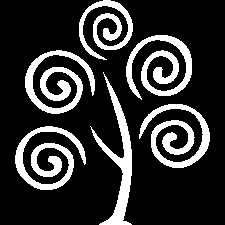

In [14]:
img1=cv2.imread("imgs/espirales_bw.bmp")
img_espirales=cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
Image(cv2.imencode('.bmp',img_espirales)[1])

--- 0.07003045082092285 seconds ---
--- 0.08701944351196289 seconds ---
--- 0.12503671646118164 seconds ---
--- 0.06524109840393066 seconds ---
--- 0.09802103042602539 seconds ---
--- 0.12202024459838867 seconds ---
---Total: 0.6751761436462402 seconds --- Objetos encontrados: 6


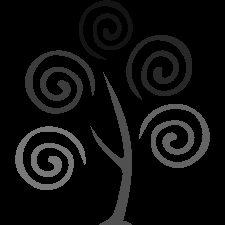

In [15]:
start_time = time.time()
img_etiqueta,N,xinis,yinis,xfines,yfines=etiquetar(img_espirales)
print("---Total: %s seconds ---" % (time.time() - start_time)+ " Objetos encontrados: "+str(N))
Image(cv2.imencode('.bmp', img_etiqueta*20)[1])

#### Etiquetado Rápido

Funciones necesarias:

In [16]:
def extenderrapido(img,imgetiquetaO,umbral,xini,yini,N):
    alto, ancho = img.shape
    imgetiqueta=aumentar(imgetiquetaO,2)
    x=xini+2
    y=yini+2
    xfin=min(xini+4,alto+1)
    yfin=min(yini+4,ancho+1)
    imgetiqueta[x,y]=N
    imgetiqueta[x-1,y]=N
    imgetiqueta[x-1,y+1]=N
    imgetiqueta[x,y-1]=N
    imgetiqueta[x,y+1]=N
    imgetiqueta[x+1,y-1]=N
    imgetiqueta[x+1,y]=N
    imgetiqueta[x+1,y+1]=N
    imgetiqueta[x-1,y-1]=N
    izq=2
    der=2
    arriba=2
    abajo=2
    cambio=False
    continuar=True
    cambio1=False
    while (continuar==True):
        if ((img[x-2,y-2]>umbral) and (imgetiqueta[x,y]==0) and ((imgetiqueta[x-arriba,y]==N)or(imgetiqueta[x,y-izq]==N)or(imgetiqueta[x+abajo,y]==N)or(imgetiqueta[x,y+der]==N)or(imgetiqueta[x+abajo,y+der]==N)or(imgetiqueta[x-arriba,y+der]==N)or(imgetiqueta[x+abajo,y-izq]==N)or(imgetiqueta[x-arriba,y-izq]==N))):
            imgetiqueta[x,y]=N
            imgetiqueta[x-1,y]=N
            imgetiqueta[x-1,y+1]=N
            imgetiqueta[x,y-1]=N
            imgetiqueta[x,y+1]=N
            imgetiqueta[x+1,y-1]=N
            imgetiqueta[x+1,y]=N
            imgetiqueta[x+1,y+1]=N
            imgetiqueta[x-1,y-1]=N
            cambio=True
            cambio1=True
            xfin=min(max(xfin,x+2),alto+1)
            yfin=min(max(yfin,y+2),ancho+1)
            xini=max(min(xini,x-2),2)
            yini=max(min(yini,y-2),2)
        y=y+2
        if (y>yfin):
            y=yini
            x=x+2
            if (x>xfin):
                x=xini
                if (cambio==False):
                    continuar=False
                else: 
                    imgetiqueta,continuar,xini,yini,xfin,yfin=extenderinvrapido(img,imgetiqueta,umbral,xini,yini,xfin,yfin,N)
                    x=xini
                    y=yini
    if (cambio1):
        return reducir(imgetiqueta,2),cambio1,xini-1,yini-1,xfin,yfin
    else: 
        return imgetiquetaO,cambio1,xini-1,yini-1,xfin,yfin

def extenderinvrapido(img,imgetiqueta,umbral,xini,yini,xfin,yfin,N):
    alto, ancho = img.shape
    x=xfin
    y=yfin
    izq=2
    der=2
    arriba=2
    abajo=2
    cambio=False
    continuar=True
    while (continuar==True):
        if ((img[x-2,y-2]>umbral) and (imgetiqueta[x,y]==0) and ((imgetiqueta[x-arriba,y]==N)or(imgetiqueta[x,y-izq]==N)or(imgetiqueta[x+abajo,y]==N)or(imgetiqueta[x,y+der]==N)or(imgetiqueta[x+abajo,y+der]==N)or(imgetiqueta[x-arriba,y+der]==N)or(imgetiqueta[x+abajo,y-izq]==N)or(imgetiqueta[x-arriba,y-izq]==N))):
            imgetiqueta[x,y]=N
            imgetiqueta[x-1,y]=N
            imgetiqueta[x-1,y+1]=N
            imgetiqueta[x,y-1]=N
            imgetiqueta[x,y+1]=N
            imgetiqueta[x+1,y-1]=N
            imgetiqueta[x+1,y]=N
            imgetiqueta[x+1,y+1]=N
            imgetiqueta[x-1,y-1]=N
            cambio=True
            xfin=min(max(xfin,x+2),alto+1)
            yfin=min(max(yfin,y+2),ancho+1)
            xini=max(min(xini,x-2),2)
            yini=max(min(yini,y-2),2)
        y=y-2
        if (y<yini):
            y=yfin
            x=x-2
            if (x<xini):
                x=xfin
                continuar=False
    return imgetiqueta,cambio,xini,yini,xfin,yfin

def etiquetarrapido(img_segmentada,umbral=10):
    alto, ancho = img_segmentada.shape
    img_etiqueta=np.zeros((alto,ancho),dtype='uint8')
    N=0;
    xinis=[]
    yinis=[]
    xfines=[]
    yfines=[]
    for x in range (0,alto,2):
        for y in range (0,ancho,2):
            if (img_segmentada[x,y]>umbral) and (img_etiqueta[x,y]==0):
                funtime=time.time()
                img_etiqueta,ok,xini,yini,xfin,yfin=extenderrapido(img_segmentada,img_etiqueta,umbral,x,y,N+1)
                if(ok): N=N+1
                print("--- %s seconds ---" % (time.time() - funtime))
                xinis.append(xini)
                yinis.append(yini)
                xfines.append(xfin)
                yfines.append(yfin)
    return img_etiqueta,N,xinis,yinis,xfines,yfines

--- 0.028005123138427734 seconds ---
--- 0.048011064529418945 seconds ---
--- 0.06512594223022461 seconds ---
--- 0.04401206970214844 seconds ---
--- 0.04801058769226074 seconds ---
--- 0.0760195255279541 seconds ---
--- 0.0 seconds ---
--- 0.3753652572631836 seconds --- Objetos encontrados: 6


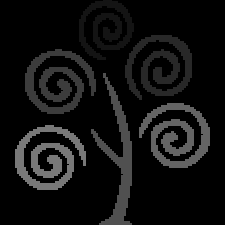

In [17]:
espirales=cv2.cvtColor(cv2.imread("espirales_bw.bmp"), cv2.COLOR_BGR2GRAY)
start_time = time.time()

img_etiqueta,N,xinis,yinis,xfines,yfines=etiquetarrapido(espirales)
print("--- %s seconds ---" % (time.time() - start_time)+ " Objetos encontrados: "+str(N))

Image(cv2.imencode('.bmp', img_etiqueta*20)[1])

#### Etiquetado sobre imagenes reales

In [17]:
start_time = time.time()
img_etiqueta,N,xinis,yinis,xfines,yfines=etiquetar(img_dilatada)
print("--- %s seconds ---" % (time.time() - start_time)+ " Objetos encontrados: "+str(N))
Image(cv2.imencode('.bmp', img_etiqueta*20)[1])

#ret_ok = cv2.imwrite('Sprint2/image_test7.png', img_etiqueta)

--- 0.29118824005126953 seconds ---
--- 0.05803322792053223 seconds ---
--- 0.21625423431396484 seconds ---
--- 0.09101366996765137 seconds ---
--- 0.08504176139831543 seconds ---
--- 0.2952389717102051 seconds ---
--- 0.21598458290100098 seconds ---
--- 1.8731417655944824 seconds --- Objetos encontrados: 7


Además podemos separar los objetos etiquetados gracias a que tenemos los marcos que los delimitan

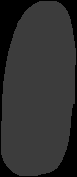

In [19]:
x = 2
Image(cv2.imencode('.bmp', img_etiqueta[xinis[x]:xfines[x],yinis[x]:yfines[x]]*20)[1])

## Funciones adicionales

#### Pseudocolor

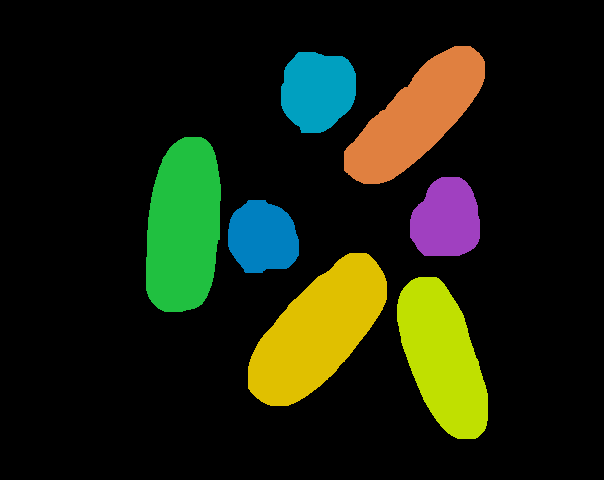

In [20]:
def colorear(img_etiqueta,escala=0):
    alto, ancho = img_etiqueta.shape
    img_pseudocolor=np.zeros((alto,ancho,3),dtype='uint8')
    colores=cv2.imread("Fotos/color30.bmp")
    for x in range (alto):
        for y in range (ancho):
            ncolor=img_etiqueta[x,y]
            if (ncolor!=0):
                ncolor+=escala                
                ncolor-=29*int(ncolor/29)
                img_pseudocolor[x,y]=colores[ncolor,0]
    return img_pseudocolor

Image(cv2.imencode('.bmp', colorear(img_etiqueta))[1])

#### Encontrar centros

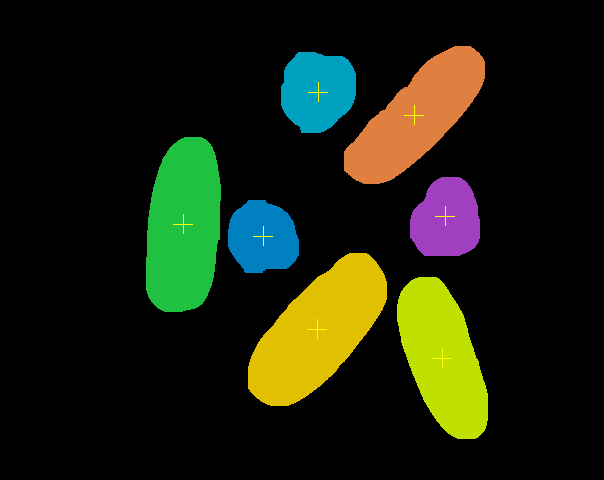

In [21]:
def dibujarcentros2(img,tam,BGR,xinis,xfines,yinis,yfines):
    margen=tam+1
    img=aumentarChan(img,margen)
    N=len(xinis)
    for x in range(N):
        img[(int((xinis[x]+xfines[x])/2)-tam+margen):(int((xinis[x]+xfines[x])/2)+tam+margen),(int((yinis[x]+yfines[x])/2)+margen),:]=np.full((2*tam,3),BGR)
        img[(int((xinis[x]+xfines[x])/2)+margen),(int((yinis[x]+yfines[x])/2)-tam+margen):(int((yinis[x]+yfines[x])/2)+tam+margen),:]=np.full((2*tam,3),BGR)
    return reducirChan(img,margen)
Image(cv2.imencode('.bmp',dibujarcentros2(colorear(img_etiqueta),10,[0,255,255],xinis,xfines,yinis,yfines))[1])

#### Númerar los objetos encontrados

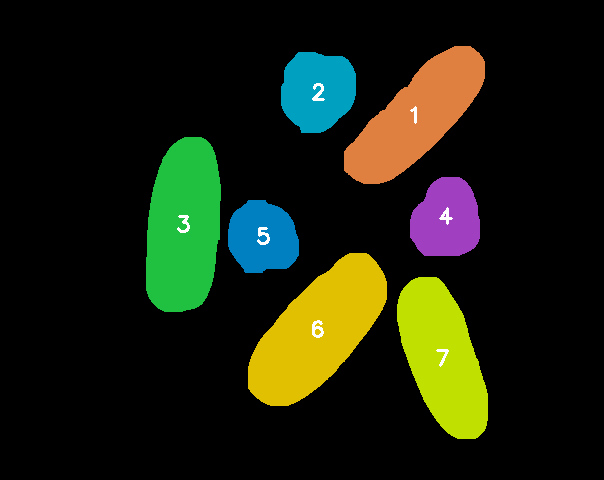

In [22]:
def numerar(img,font,fontScale,BGR,xinis,xfines,yinis,yfines):
    N=len(xinis)
    fontColor = BGR
    lineType = int(fontScale/0.7)+1
    for x in range(N):
        bottomLeftCornerOfText = (int((yinis[x]+yfines[x])/2-10*fontScale),int((xinis[x]+xfines[x])/2+10*fontScale))
        cv2.putText (img, str(x+1) ,bottomLeftCornerOfText, font, fontScale,fontColor,lineType)
    return img
Image(cv2.imencode('.bmp',numerar(colorear(img_etiqueta),cv2.FONT_HERSHEY_SIMPLEX,0.7,[255,255,255],xinis,xfines,yinis,yfines))[1])

#### Medir objetos

In [23]:
def medirobjetos(img,N):
    img=aumentar(img,1)
    areas=np.zeros(N,dtype='int')
    perimetros=np.zeros(N,dtype='int')
    circularidad=np.zeros(N,dtype='int')
    for x in range(1,img.shape[0]-1):
        for y in range(1,img.shape[1]-1):
            if (img[x,y]!=0):
                aux=img[x,y]
                if ((img[x-1,y-1]==aux)and(img[x-1,y]==aux)and(img[x-1,y+1]==aux)and(img[x,y-1]==aux)and(img[x,y+1]==aux)and(img[x+1,y-1]==aux)and(img[x+1,y]==aux)and(img[x+1,y+1]==aux)):
                    areas[aux-1]=areas[aux-1]+1
                else:
                    areas[aux-1]=areas[aux-1]+1
                    perimetros[aux-1]=perimetros[aux-1]+1
    circularidad=(4*np.pi*areas)/(perimetros**2)
    return areas,perimetros,circularidad

area,per,circ=medirobjetos(img_etiqueta,N)
for x in range(N):
    if (circ[x]>0.6):
        tipo='garbanzo'
    else:
        tipo='habichuela'
    print('Objeto: '+str(x+1)+' Área = '+str(area[x])+' Perimetro = '+str(per[x])+' Tipo = '+str("{:.4f}".format(circ[x]))+' Circularidad = '+tipo)

Objeto: 1 Área = 9692 Perimetro = 554 Tipo = 0.3968 Circularidad = habichuela
Objeto: 2 Área = 4868 Perimetro = 308 Tipo = 0.6449 Circularidad = garbanzo
Objeto: 3 Área = 10877 Perimetro = 496 Tipo = 0.5556 Circularidad = habichuela
Objeto: 4 Área = 4453 Perimetro = 294 Tipo = 0.6474 Circularidad = garbanzo
Objeto: 5 Área = 4116 Perimetro = 284 Tipo = 0.6413 Circularidad = garbanzo
Objeto: 6 Área = 12064 Perimetro = 580 Tipo = 0.4507 Circularidad = habichuela
Objeto: 7 Área = 9649 Perimetro = 502 Tipo = 0.4812 Circularidad = habichuela


## Etapa completa de procesamiento

Por favor, indica la imagen a procesar (1-9):  1


El tamaño de la matriz de imagen es:  (480, 604, 3)
La imagen es del tipo: <class 'numpy.ndarray'> de uint8
--- 0.08420109748840332 seconds ---
--- 0.36550068855285645 seconds ---
--- 0.42809319496154785 seconds ---
--- 0.21205520629882812 seconds ---
--- 0.17996859550476074 seconds ---
--- 0.14809799194335938 seconds ---
--- 0.1960916519165039 seconds ---
--- 0.11205697059631348 seconds ---
--- 2.889880418777466 seconds --- Objetos encontrados: 8


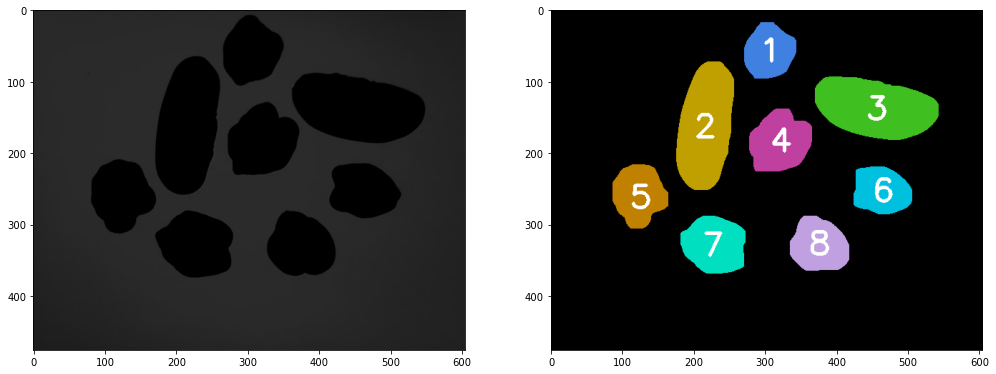

In [24]:
nombre_img = input('Por favor, indica la imagen a procesar (1-9): ')
img_demo = cv2.imread('imgs/demo'+nombre_img+'.jpg')
#img = cv2.imread('imgs/l000005.bmp')
Image(cv2.imencode('.jpg',img)[1])

# Mostrar el tamaño de la matriz de imagen
alto, ancho, canales = img.shape
print('El tamaño de la matriz de imagen es: ', img.shape)

# Mostrar el tipo de matriz
print('La imagen es del tipo:',type(img),'de', img.dtype)

#Image(cv2.imencode('.jpg', img_demo)[1])

# Conversión a imagen de grises
img_gray = cv2.cvtColor(img_demo, cv2.COLOR_BGR2GRAY)
i=img_gray.copy()

# Umbralización con el método de Otsu 
start_time = time.time()
umbral, img_segmentada = cv2.threshold(img_gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

#Erosión y dilatación
kernel = np.ones((5,5),np.uint8)
img_erosionada = cv2.erode(img_segmentada,kernel,iterations = 6)
img_dilatada = cv2.dilate(img_erosionada,kernel,iterations = 4)

#Etiquetado
start_time = time.time()
img_etiqueta,N,xinis,yinis,xfines,yfines=etiquetar(img_dilatada)
print("--- %s seconds ---" % (time.time() - start_time)+ " Objetos encontrados: "+str(N))
#Image(cv2.imencode('.bmp',numerar(colorear(img_etiqueta),cv2.FONT_HERSHEY_SIMPLEX,1.5,[255,255,255],xinis,xfines,yinis,yfines))[1])

# figure size in inches optional
rcParams['figure.figsize'] = 17 ,13

# display images
fig, ax = plt.subplots(1,2)
ax[0].imshow(img_demo);
ax[1].imshow(numerar(colorear(img_etiqueta),cv2.FONT_HERSHEY_SIMPLEX,1.5,[255,255,255],xinis,xfines,yinis,yfines));